In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
raw_df = pd.read_csv("./data/msg.csv")
df = raw_df[["StrContent", "StrTime", "NickName"]]
# df

In [3]:
df = df.assign(Time = pd.to_datetime(df["StrTime"]))
df = df.drop("StrTime", axis=1)
df = df[df["Time"] >= "2022-10-12"]
df = df.assign(
    Year = df["Time"].dt.year,
    Month = df["Time"].dt.month,
    Week = df["Time"].dt.isocalendar().week,
    Day = df["Time"].dt.day,
)

In [4]:
count_df = pd.DataFrame(df.value_counts(["Year", "Month", "Week", "Day"]).sort_index())
# count_df

In [5]:
# a new column: Week, which is the date of the first day of the week, e.g. 2021-01-04
count_df = count_df.assign(
    Year = count_df.index.get_level_values("Year"),
    Month = count_df.index.get_level_values("Month"),
    Week = count_df.index.get_level_values("Week"),
    Day = count_df.index.get_level_values("Day"),
)
count_df["Date"] = pd.to_datetime(count_df[["Year", "Month", "Day"]])
count_df = count_df.reset_index(drop=True)

# for missing days, fill the Year, Month, Week, Day columns but add a 0 count
count_df = count_df.set_index("Date")
date_range = pd.date_range(count_df.index.min(), count_df.index.max())
count_df = count_df.reindex(date_range, fill_value=0)
count_df = count_df.assign(
    Year = count_df.index.year,
    Month = count_df.index.month,
    Week = count_df.index.isocalendar().week,
    Day = count_df.index.day,
)
count_df = count_df.reset_index(drop=False, names=["Date"])

# count_df

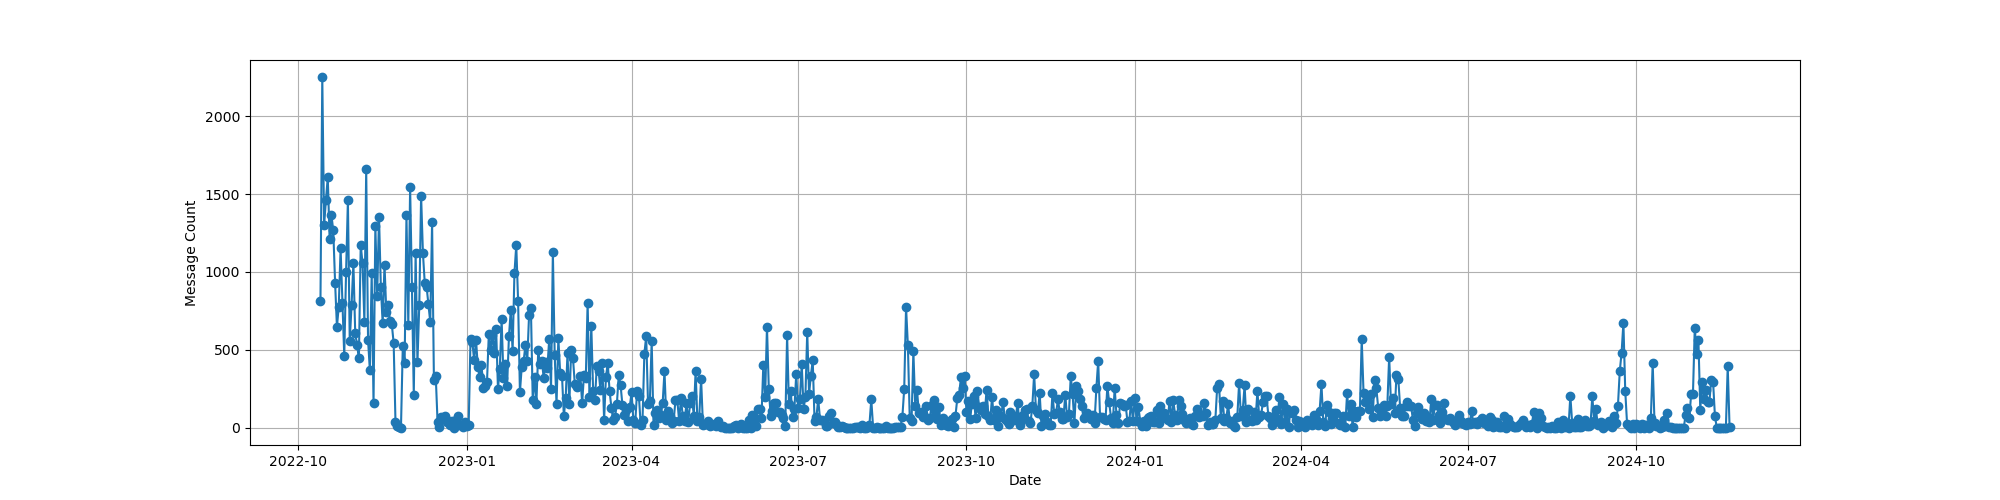

In [6]:
import mplcursors

plt.figure(figsize=(20, 5))
plt.plot(
    count_df["Date"],
    count_df["count"],
    label="Message Count",
    marker="o",
)
mplcursors.cursor(hover=True)
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.grid()
plt.show()

In [7]:
split_point = "2024-08-01"
train_df = count_df[count_df["Date"] < split_point]
test_df = count_df[count_df["Date"] >= split_point]
train_df.shape, test_df.shape

((658, 6), (113, 6))

In [8]:
target = "count"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((658, 5), (658,), (113, 5), (113,))

In [9]:
res = {
    "Model": [],
    "Name": [],
    "Train score": [],
    "Test score": [],
}

In [10]:
from sklearn.compose import make_column_transformer


preprocessor = make_column_transformer(
    ("drop", ["Date"]),
    remainder="passthrough",
)

In [11]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


linear_model = make_pipeline(preprocessor, Ridge())
linear_model.fit(X_train, y_train)
linear_model.score(X_train, y_train), linear_model.score(X_test, y_test)

(0.30601073772317233, -1.6525406666594864)

In [12]:
def score_model(pipe, name, X_train, y_train, X_test, y_test, res=res):
    pipe.fit(X_train, y_train)
    model_name = pipe.steps[-1][0]
    res["Model"].append(pipe.named_steps[model_name].__class__.__name__)
    res["Name"].append(name)
    res["Train score"].append(pipe.score(X_train, y_train))
    res["Test score"].append(pipe.score(X_test, y_test)
    )
    return res

In [13]:
def plot_predictions(count_df, train_df, test_df, train_predictions, test_predictions, title):
    plt.figure(figsize=(20, 5))
    marker_size = 5
    plt.plot(
        count_df["Date"],
        count_df["count"],
        label="Message Count",
        marker="o",
    )
    plt.plot(
        train_df["Date"],
        train_predictions,
        label="Train Prediction",
        color="green",
        linestyle="--",
        marker="x",
        markersize=marker_size
    )
    plt.plot(
        test_df["Date"],
        test_predictions,
        label="Test Prediction",
        color="red",
        linestyle="--",
        marker="x",
        markersize=marker_size
    )
    mplcursors.cursor(hover=True)
    plt.xlabel("Date")
    plt.ylabel("Message Count")
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
from sklearn.dummy import DummyRegressor

dummy_model = make_pipeline(preprocessor, DummyRegressor())
score_model(dummy_model, "Dummy", X_train, y_train, X_test, y_test)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.0,-0.881709


In [15]:
score_model(linear_model, "Default Linear", X_train, y_train, X_test, y_test)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541


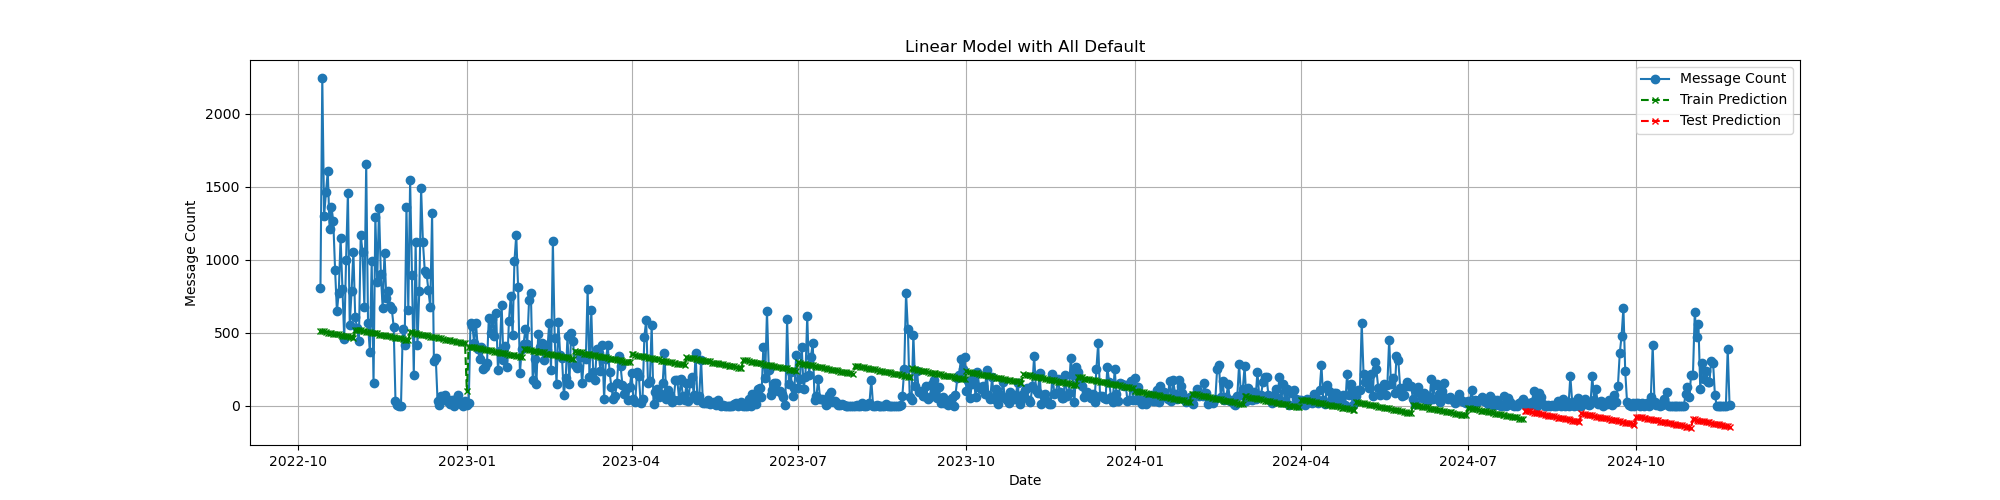

In [16]:
plot_predictions(count_df, train_df, test_df, linear_model.predict(X_train), linear_model.predict(X_test), "Linear Model with All Default")

In [17]:
from sklearn.preprocessing import PolynomialFeatures


X_train_interact = X_train.copy()
X_test_interact = X_test.copy()
preprocessor_interact = make_column_transformer(
    ("drop", ["Date"]),
    (PolynomialFeatures(interaction_only=True, include_bias=False), ["Year", "Month", "Week", "Day"]),
    remainder="passthrough",
)

interact_model = make_pipeline(preprocessor_interact, Ridge())
score_model(interact_model, "Interact", X_train_interact, y_train, X_test_interact, y_test)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447


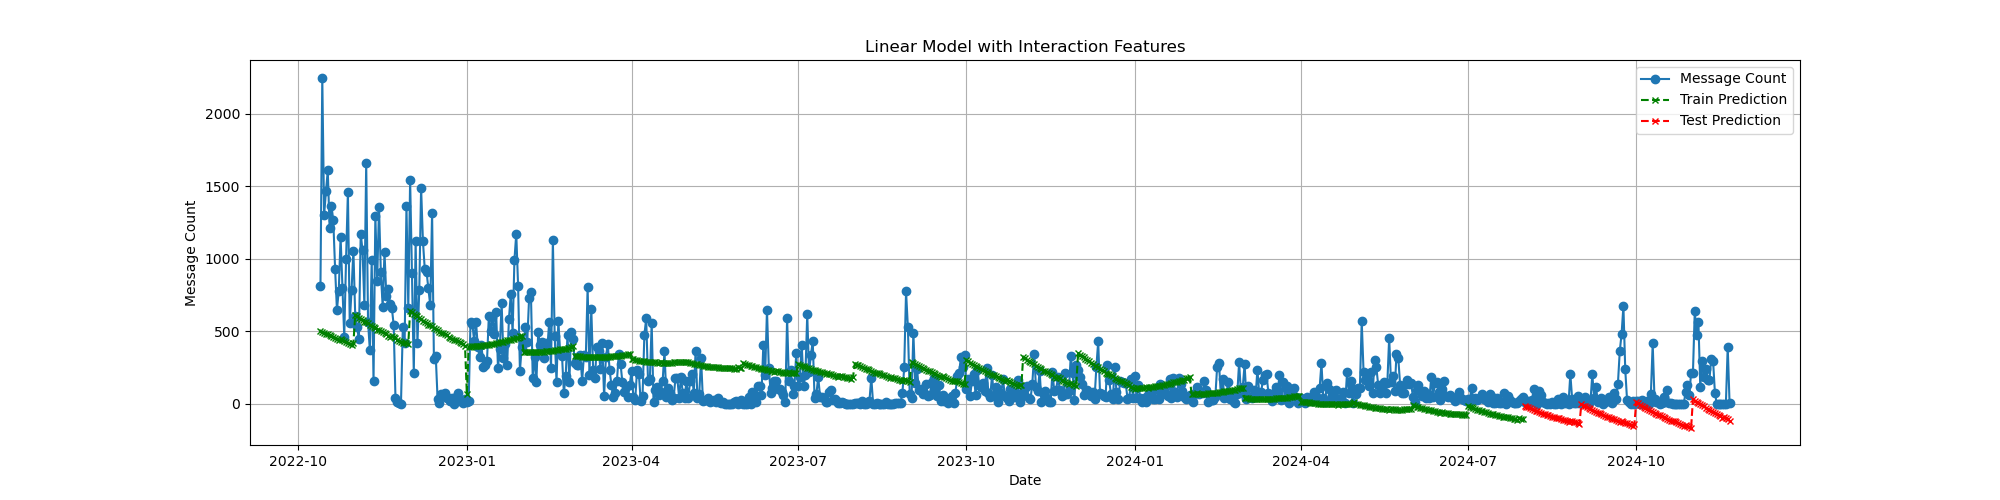

In [18]:
plot_predictions(count_df, train_df, test_df, interact_model.predict(X_train_interact), interact_model.predict(X_test_interact), "Linear Model with Interaction Features")

In [19]:
train_df_lag = train_df.copy()
test_df_lag = test_df.copy()

num_lag = 14
for i in range(1, num_lag+1):
    train_df_lag[f"count_lag_{i}"] = train_df_lag["count"].shift(i)
    test_df_lag[f"count_lag_{i}"] = test_df_lag["count"].shift(i)

train_df_lag = train_df_lag.fillna(train_df_lag.mean())
test_df_lag = test_df_lag.fillna(train_df_lag.mean())

X_train_lag = train_df_lag.drop(columns=[target])
y_train_lag = train_df_lag[target]
X_test_lag = test_df_lag.drop(columns=[target])
y_test_lag = test_df_lag[target]

X_train_lag.shape, y_train_lag.shape, X_test_lag.shape, y_test_lag.shape

((658, 19), (658,), (113, 19), (113,))

In [20]:
pd.concat([X_test_lag, y_test_lag], axis=1)

,Date,Year,Month,Week,Day,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,count_lag_8,count_lag_9,count_lag_10,count_lag_11,count_lag_12,count_lag_13,count_lag_14,count
658,2024-08-01,2024,8,31,1,209.155251,209.429878,209.723664,210.039755,210.352221,210.673313,210.984639,211.272308,211.514638,211.841049,212.058733,212.374613,212.699225,213.023292,14
659,2024-08-02,2024,8,31,2,14.000000,209.429878,209.723664,210.039755,210.352221,210.673313,210.984639,211.272308,211.514638,211.841049,212.058733,212.374613,212.699225,213.023292,3
660,2024-08-03,2024,8,31,3,3.000000,14.000000,209.723664,210.039755,210.352221,210.673313,210.984639,211.272308,211.514638,211.841049,212.058733,212.374613,212.699225,213.023292,17
661,2024-08-04,2024,8,31,4,17.000000,3.000000,14.000000,210.039755,210.352221,210.673313,210.984639,211.272308,211.514638,211.841049,212.058733,212.374613,212.699225,213.023292,5
662,2024-08-05,2024,8,32,5,5.000000,17.000000,3.000000,14.000000,210.352221,210.673313,210.984639,211.272308,211.514638,211.841049,212.058733,212.374613,212.699225,213.023292,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2024-11-17,2024,11,46,17,0.000000,0.000000,0.000000,76.000000,294.000000,308.000000,166.000000,161.000000,241.000000,183.000000,295.000000,115.000000,560.000000,475.000000,0
767,2024-11-18,2024,11,47,18,0.000000,0.000000,0.000000,0.000000,76.000000,294.000000,308.000000,166.000000,161.000000,241.000000,183.000000,295.000000,115.000000,560.000000,0
768,2024-11-19,2024,11,47,19,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000,294.000000,308.000000,166.000000,161.000000,241.000000,183.000000,295.000000,115.000000,0
769,2024-11-20,2024,11,47,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000,294.000000,308.000000,166.000000,161.000000,241.000000,183.000000,295.000000,392


In [21]:
linear_lag_model = make_pipeline(preprocessor, Ridge())
score_model(linear_lag_model, "Lag Linear", X_train_lag, y_train_lag, X_test_lag, y_test_lag)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933


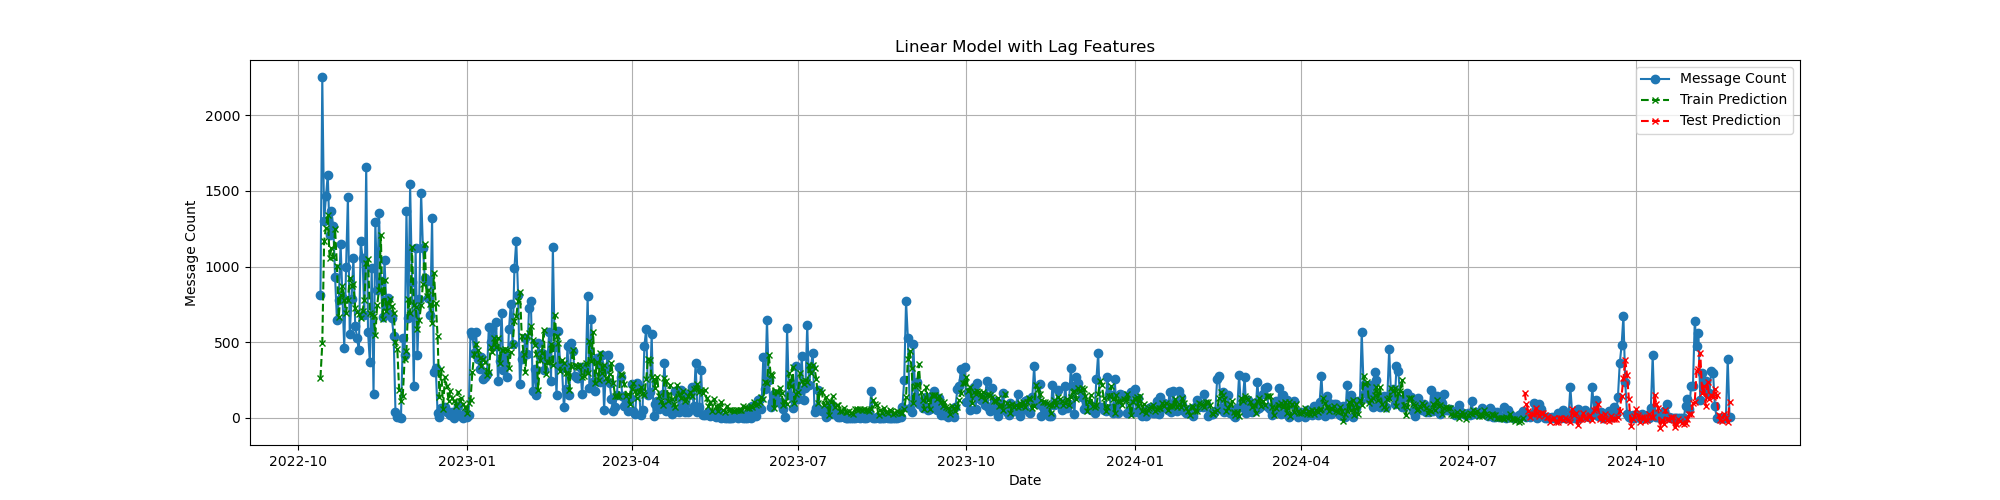

In [22]:
plot_predictions(count_df, train_df_lag, test_df_lag, linear_lag_model.predict(X_train_lag), linear_lag_model.predict(X_test_lag), "Linear Model with Lag Features")

In [23]:
from sklearn.ensemble import RandomForestRegressor


rf_model = make_pipeline(preprocessor, RandomForestRegressor())
score_model(rf_model, "Random Forest", X_train, y_train, X_test, y_test)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933
4,RandomForestRegressor,Random Forest,0.943415,-0.356066


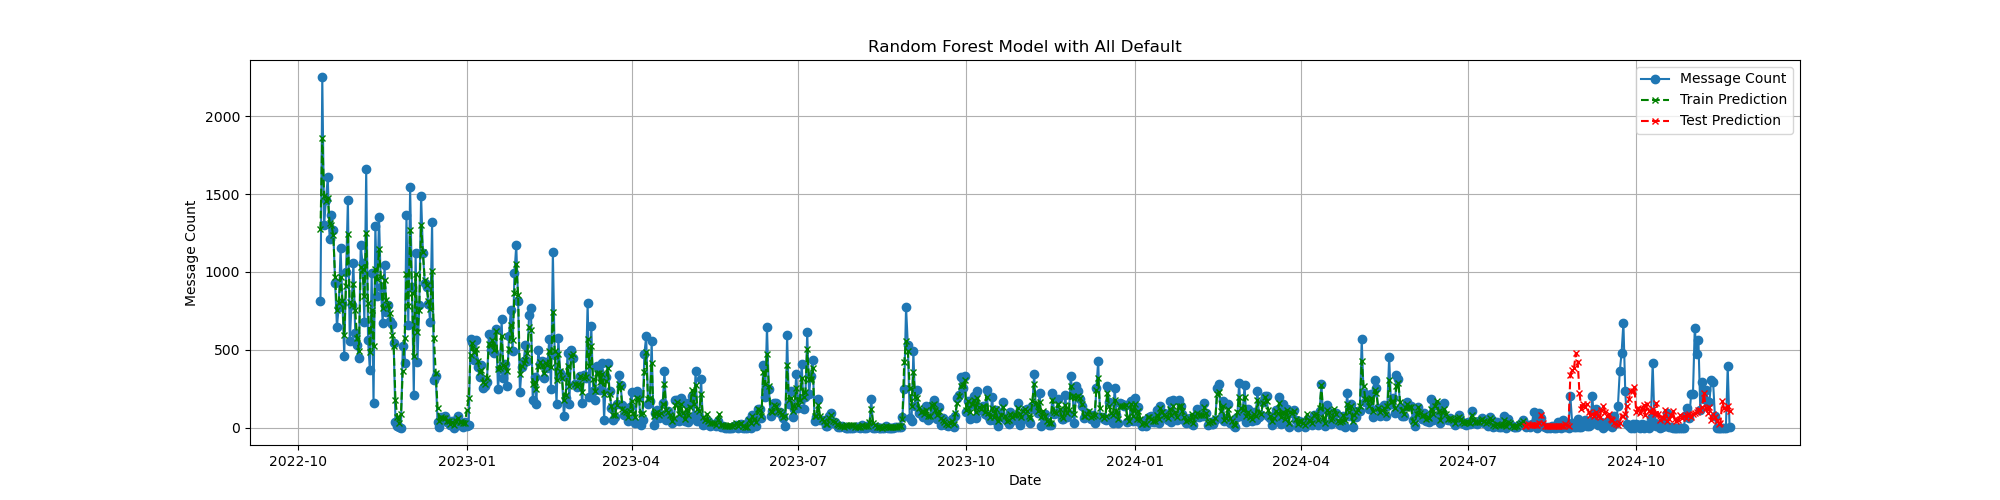

In [24]:
plot_predictions(count_df, train_df, test_df, rf_model.predict(X_train), rf_model.predict(X_test), "Random Forest Model with All Default")

In [25]:
from sklearn.preprocessing import OneHotEncoder


preprocessor_categorical = make_column_transformer(
    ("drop", ["Date"]),
    (OneHotEncoder(handle_unknown="ignore"),
     ["Year", "Month", "Week", "Day"]),
    remainder=PolynomialFeatures(interaction_only=True, include_bias=False),
)

linear_categorical_model = make_pipeline(preprocessor_categorical, Ridge())
score_model(linear_categorical_model, "Categorical Linear",
            X_train, y_train, X_test, y_test)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933
4,RandomForestRegressor,Random Forest,0.943415,-0.356066
5,Ridge,Categorical Linear,0.580288,-0.973626


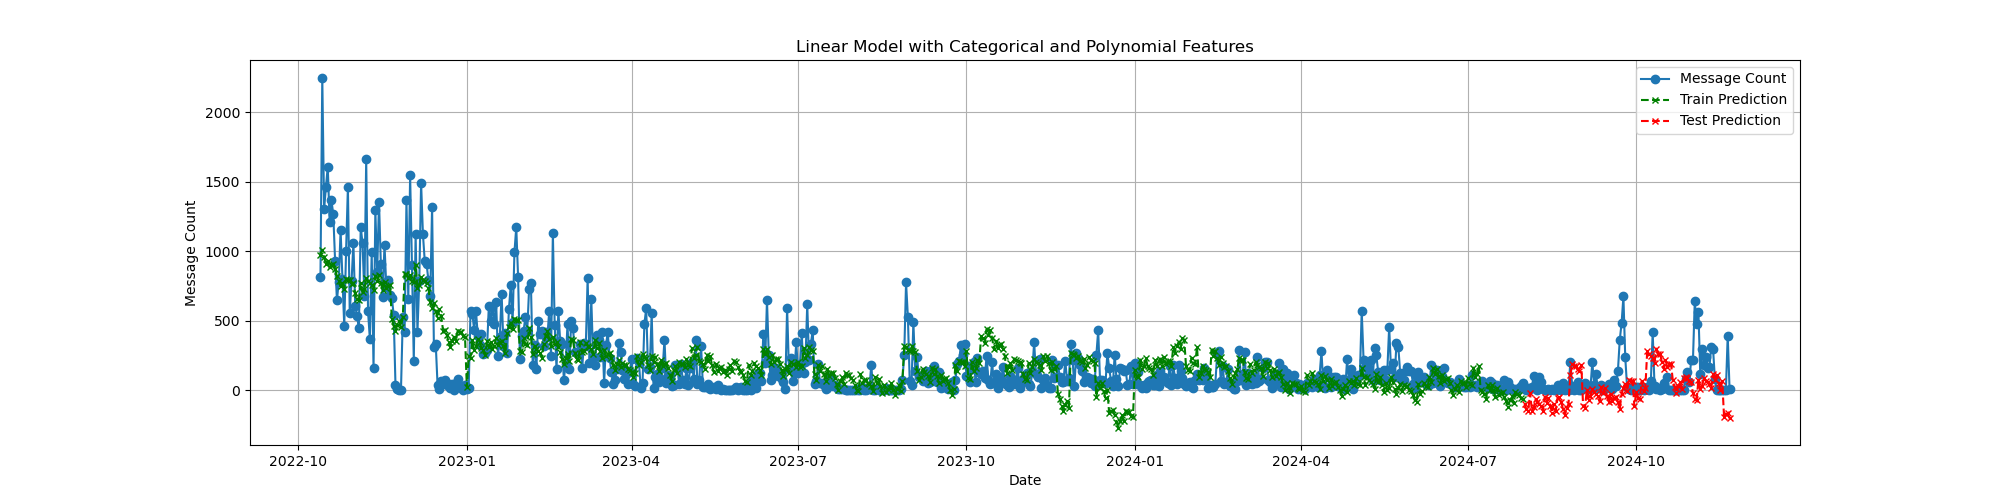

In [26]:
plot_predictions(count_df, train_df, test_df, linear_categorical_model.predict(X_train), linear_categorical_model.predict(X_test), "Linear Model with Categorical and Polynomial Features")

In [27]:
preprocessor_categorical.get_feature_names_out().shape, preprocessor_categorical.fit_transform(X_train).shape

((98,), (658, 98))

In [28]:
# linear categorical lag model
X_train_encoded = preprocessor_categorical.fit_transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=preprocessor_categorical.get_feature_names_out())
X_test_encoded = preprocessor_categorical.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=preprocessor_categorical.get_feature_names_out())


# conbine X and y to do lag features
train_df_encoded = pd.concat([X_train_encoded, y_train], axis=1)
test_df_encoded = pd.concat(
    [X_test_encoded, y_test.reset_index(drop=True)], axis=1)

# lag features
for i in range(1, num_lag+1):
    train_df_encoded[f"count_lag_{i}"] = train_df_encoded["count"].shift(i)
    test_df_encoded[f"count_lag_{i}"] = test_df_encoded["count"].shift(i)

train_df_encoded = train_df_encoded.fillna(train_df_encoded.mean())
test_df_encoded = test_df_encoded.fillna(test_df_encoded.mean())

X_train_encoded_lag = train_df_encoded.drop(columns=[target])
y_train_encoded_lag = train_df_encoded[target]
X_test_encoded_lag = test_df_encoded.drop(columns=[target])
y_test_encoded_lag = test_df_encoded[target]

In [29]:
linear_categorical_lag_model = make_pipeline(Ridge())
score_model(linear_categorical_lag_model, "Categorical Lag Linear",
            X_train_encoded_lag, y_train_encoded_lag, X_test_encoded_lag, y_test_encoded_lag)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933
4,RandomForestRegressor,Random Forest,0.943415,-0.356066
5,Ridge,Categorical Linear,0.580288,-0.973626
6,Ridge,Categorical Lag Linear,0.687007,-0.179878


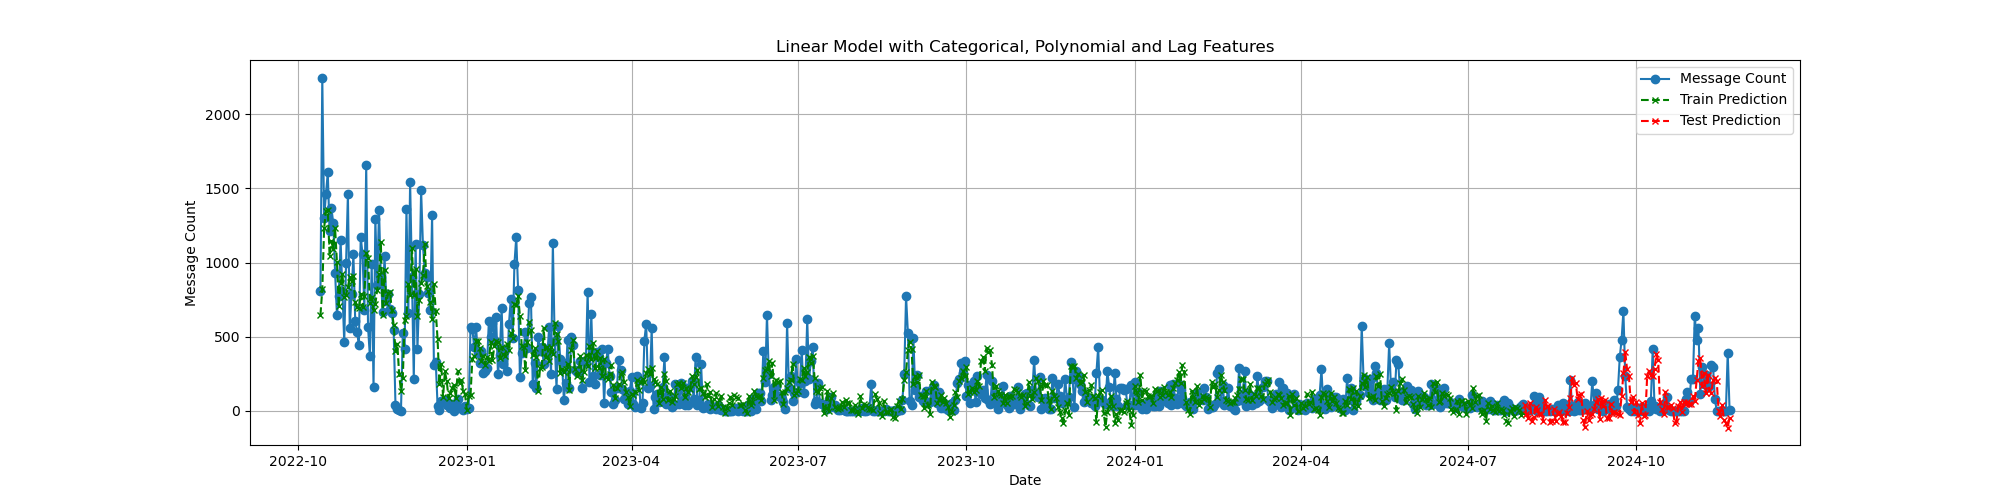

In [30]:
plot_predictions(count_df, train_df_lag, test_df_lag, linear_categorical_lag_model.predict(X_train_encoded_lag), linear_categorical_lag_model.predict(X_test_encoded_lag), "Linear Model with Categorical, Polynomial and Lag Features")

In [31]:
# random forest categorical lag model
rf_categorical_lag_model = make_pipeline(RandomForestRegressor())
score_model(rf_categorical_lag_model, "Categorical Lag Random Forest",
            X_train_encoded_lag, y_train_encoded_lag, X_test_encoded_lag, y_test_encoded_lag)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933
4,RandomForestRegressor,Random Forest,0.943415,-0.356066
5,Ridge,Categorical Linear,0.580288,-0.973626
6,Ridge,Categorical Lag Linear,0.687007,-0.179878
7,RandomForestRegressor,Categorical Lag Random Forest,0.943210,0.084796


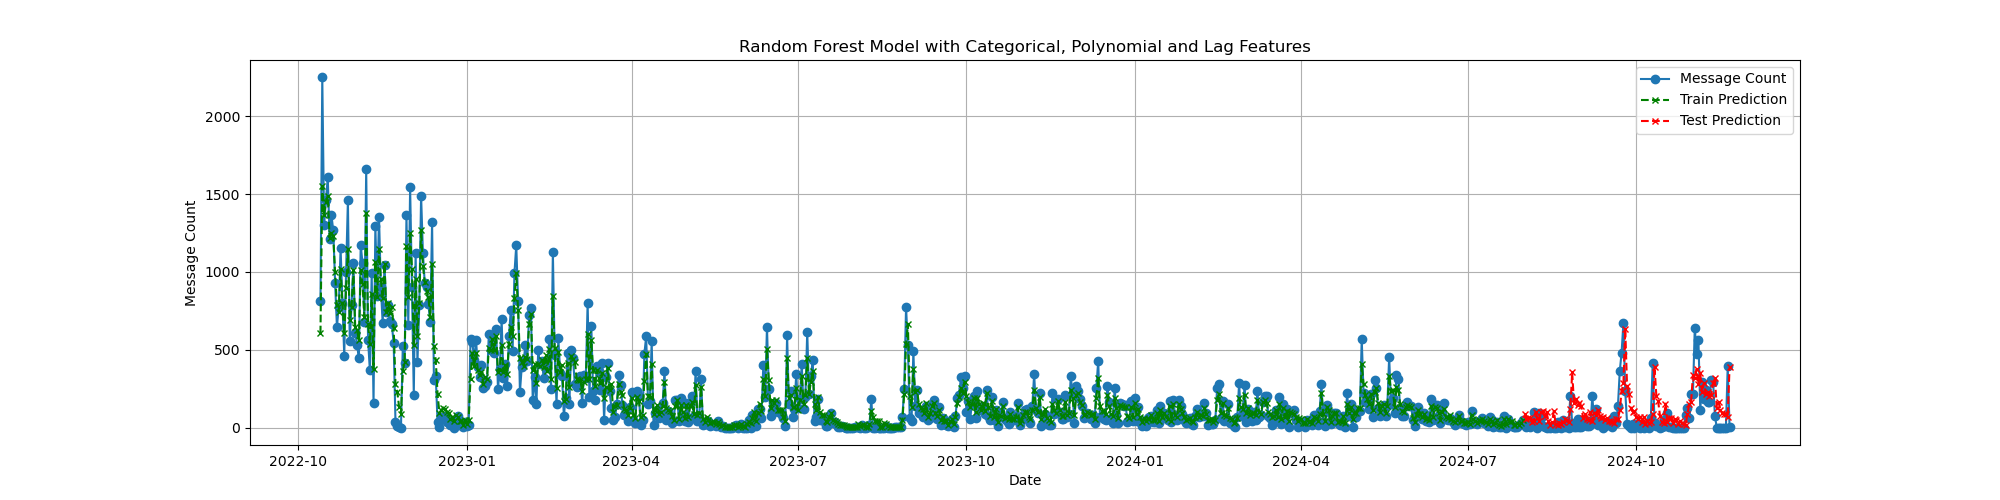

In [32]:
plot_predictions(count_df, train_df_lag, test_df_lag, rf_categorical_lag_model.predict(X_train_encoded_lag), rf_categorical_lag_model.predict(X_test_encoded_lag), "Random Forest Model with Categorical, Polynomial and Lag Features")

In [33]:
# XGBoost with categorical lag model
from xgboost import XGBRegressor

xgb_categorical_lag_model = make_pipeline(XGBRegressor())
score_model(xgb_categorical_lag_model, "Categorical Lag XGBoost",
            X_train_encoded_lag, y_train_encoded_lag, X_test_encoded_lag, y_test_encoded_lag)
pd.DataFrame(res)

,Model,Name,Train score,Test score
0,DummyRegressor,Dummy,0.000000,-0.881709
1,Ridge,Default Linear,0.306011,-1.652541
2,Ridge,Interact,0.328886,-1.262447
3,Ridge,Lag Linear,0.628112,0.172933
4,RandomForestRegressor,Random Forest,0.943415,-0.356066
5,Ridge,Categorical Linear,0.580288,-0.973626
6,Ridge,Categorical Lag Linear,0.687007,-0.179878
7,RandomForestRegressor,Categorical Lag Random Forest,0.943210,0.084796
8,XGBRegressor,Categorical Lag XGBoost,0.999913,-0.300030


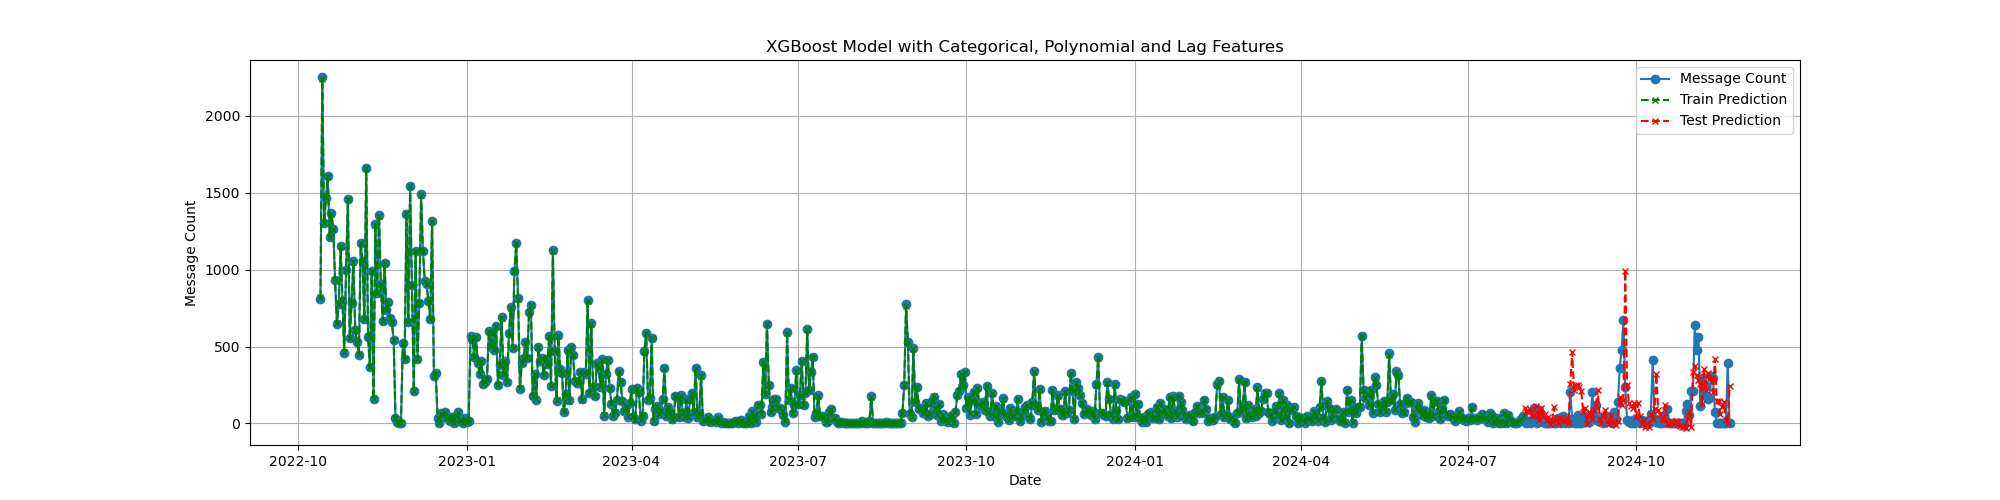

In [34]:
plot_predictions(count_df, train_df_lag, test_df_lag, xgb_categorical_lag_model.predict(X_train_encoded_lag), xgb_categorical_lag_model.predict(X_test_encoded_lag), "XGBoost Model with Categorical, Polynomial and Lag Features")